# Analyze Non-Neurons

Analyze non-neurons to construct cell types using data from "Transcriptomic diversity of cell types across the adult human brain," published on bioRxiv, 2022 (DOI: [10.1101/2022.10.12.511898](https://doi.org/10.1101/2022.10.12.511898)). For more information, see also the [`scanpy` documentation](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

First, load relevant packages.

In [1]:
# standard imports
import numpy as np
import pandas as pd
import os
import time

# path manipulation
from pathlib import Path

# string manipulation
import re

# single cell analysis
import scanpy as sc
import anndata

# matplotlib imports
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# import project config file
import sys
sys.path.append('../..')
import project_config

Note that directories are relative to the project path.

In [2]:
# set directories
neuroKG_dir = project_config.PROJECT_DIR / 'Data' / 'NeuroKG'
ensembl_dir = project_config.PROJECT_DIR / 'Data' / 'Ensembl'
snRNAseq_dir = project_config.PROJECT_DIR / 'Data' / 'CELLxGENE' / 'linnarsson'

# define output directory
output_dir = project_config.PROJECT_DIR / 'Data' / 'CELLxGENE' / 'linnarsson' / 'processed'

Read the `.h5ad` AnnData files containing the nervous and non-nervous data.

In [3]:
# read nervous data
non_neurons = sc.read_h5ad(snRNAseq_dir / 'Nonneurons.h5ad')
non_neurons

AnnData object with n_obs × n_vars = 888263 × 59480
    obs: 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'dissection', 'cell_cycle_score', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start'
    uns: 'batch_condition', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

Show the gene-level metadata.

In [4]:
# show gene level metadata
non_neurons.var.head()

,Biotype,Chromosome,End,Gene,Start
Accession,,,,,
Cas9,protein_coding,chrEXTRA,12412,transgen-Cas9,8081
EGFP,protein_coding,chrEXTRA,13152,marker-EGFP,12433
ENSG00000000003.15,n/a,chrX,100639991,TSPAN6,100627108
ENSG00000000005.6,n/a,chrX,100599885,TNMD,100584936
ENSG00000000419.13,n/a,chr20,50958555,DPM1,50934867


Perform quality checks.

In [5]:
# annotate mitochondrial genes
non_neurons.var['mt'] = non_neurons.var.Gene.str.startswith('MT-')

# perform quality control
sc.pp.calculate_qc_metrics(non_neurons, qc_vars = ['mt'], percent_top = None, log1p = True, inplace = True)

Create violin plot of some of the computed quality measures:
* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

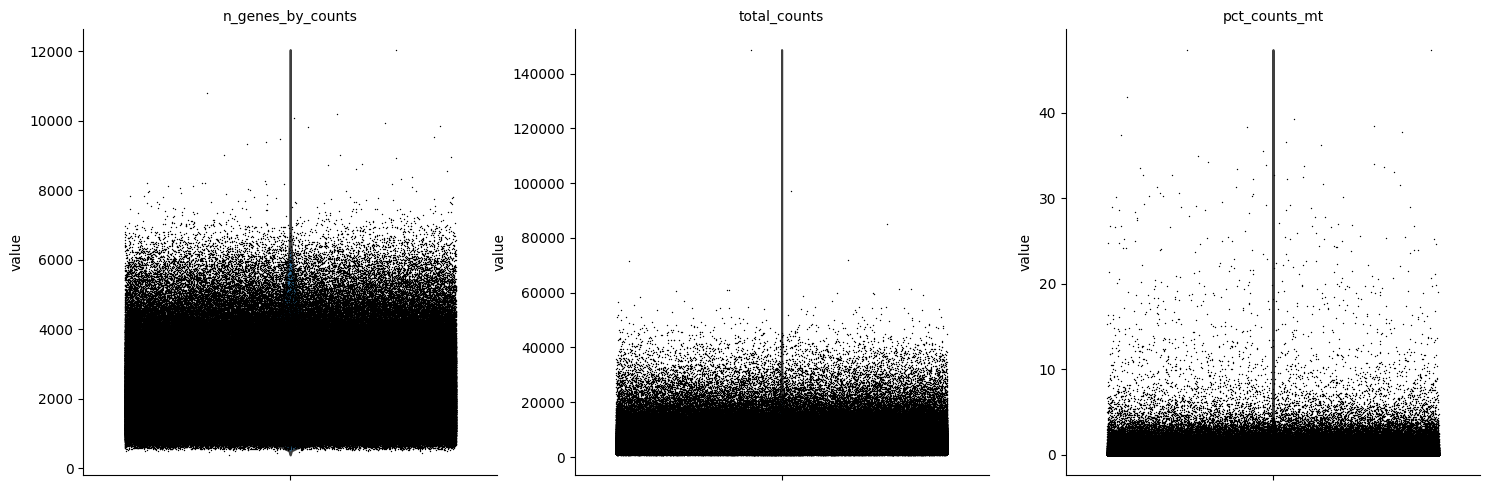

In [6]:
# create violin plot
sc.pl.violin(non_neurons, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

Visualize results in scatter plot.

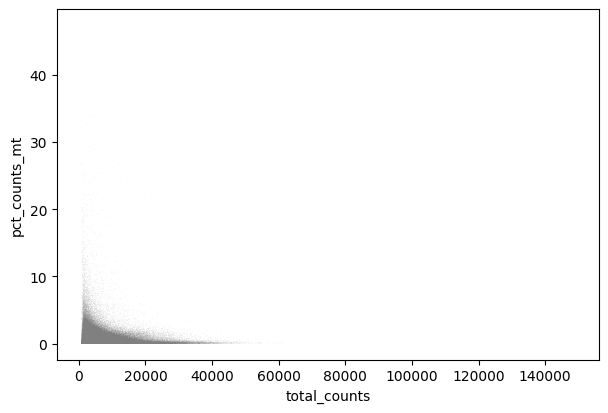

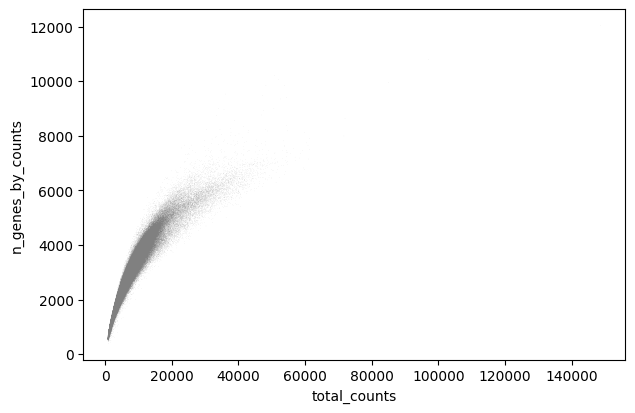

In [7]:
sc.pl.scatter(non_neurons, x = 'total_counts', y = 'pct_counts_mt')
sc.pl.scatter(non_neurons, x = 'total_counts', y = 'n_genes_by_counts')

Remove cells that have too many mitochondrial genes expressed or too many total counts. By inspection of the above plots, we choose a threshold of 15% mitochondrial genes and 7,000 total counts.

In [8]:
# number of cells before filtering
pre_filtered_cells = non_neurons.n_obs

# thresholds determined by inspection
non_neurons = non_neurons[non_neurons.obs.n_genes_by_counts < 7000, :]
non_neurons = non_neurons[non_neurons.obs.pct_counts_mt < 5, :]

# number of cells after filtering
post_filtered_cells = non_neurons.n_obs
print('Number of cells removed: {:d}'.format(pre_filtered_cells - post_filtered_cells))

non_neurons

Number of cells removed: 2965


View of AnnData object with n_obs × n_vars = 885298 × 59480
    obs: 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'dissection', 'cell_cycle_score', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'batch_condition', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells. Next, apply a logarithmic transformation.

In [9]:
# total count normalize the data
sc.pp.normalize_total(non_neurons, target_sum = 1e4)

# apply log transformation
sc.pp.log1p(non_neurons)

/n/data1/hms/dbmi/zitnik/lab/users/an252/NeuroKG/neuroKG/neuroKG_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Add Annotations

Merge gene-level metadata with other annotations.

In [10]:
# read protein coding genes and fix names
mart = pd.read_csv(ensembl_dir / 'mart_export.txt')
new_mart_names = [x.lower() for x in mart.columns.values]
new_mart_names = [re.sub('\\s\\([^)]+\\)', '', x) for x in new_mart_names]
new_mart_names = [re.sub('\\s+', '_', x) for x in new_mart_names]
mart.columns = new_mart_names

# print dimension of annotation
print("Original dimension: {}".format(mart.shape))

# remove specified columns
columns_to_remove = ['gene_synonym', 'transcript_stable_id', 'protein_stable_id', 'gene_stable_id_version', 'protein_stable_id_version', 'transcript_stable_id_version']
mart = mart.drop(columns_to_remove, axis=1)

# remove duplicate rows
mart = mart.drop_duplicates(['gene_stable_id']).reset_index(drop = True)

# print dimension of annotation
print("Removing duplicate Ensembl IDs: {}".format(mart.shape))

# filter out rows with missing ncbi_gene_id
mart = mart.dropna(subset=['ncbi_gene_id'])
mart['ncbi_gene_id'] = mart['ncbi_gene_id'].astype(int)

# print dimension of annotation
print("Removing missing NCBI gene IDs: {}".format(mart.shape))

# show head
mart.head()

Original dimension: (635615, 14)
Removing duplicate Ensembl IDs: (69299, 8)
Removing missing NCBI gene IDs: (29921, 8)


,gene_stable_id,gene_type,gene_description,gene_start,gene_end,gene_name,ncbi_gene_description,ncbi_gene_id
5,ENSG00000198888,protein_coding,mitochondrially encoded NADH:ubiquinone oxidor...,3307,4262,MT-ND1,NADH dehydrogenase subunit 1,4535
9,ENSG00000198763,protein_coding,mitochondrially encoded NADH:ubiquinone oxidor...,4470,5511,MT-ND2,NADH dehydrogenase subunit 2,4536
15,ENSG00000198804,protein_coding,mitochondrially encoded cytochrome c oxidase I...,5904,7445,MT-CO1,cytochrome c oxidase subunit I,4512
16,ENSG00000210151,Mt_tRNA,mitochondrially encoded tRNA-Ser (UCN) 1 [Sour...,7446,7514,MT-TS1,microRNA 12136,113219467
18,ENSG00000198712,protein_coding,mitochondrially encoded cytochrome c oxidase I...,7586,8269,MT-CO2,cytochrome c oxidase subunit II,4513


Merge with the gene-level metadata.

In [11]:
# clean names of non_neurons by removing version
non_neurons.var.index = [re.sub('\\.[0-9]+', '', x) for x in non_neurons.var.index]

# check how many genes are in the nervous system data
non_neurons_genes = set(non_neurons.var_names)
print('Number of genes in Linnarsson et al.:', len(non_neurons_genes))

# check how many genes are in the mart data
mart_genes = set(mart['gene_stable_id'])
print('Number of genes in annotation:', len(mart_genes))

# check how many genes are in both
int_genes = mart_genes.intersection(non_neurons_genes)
print('Number of genes in both:', len(int_genes))

# get genes in snRNA-seq data but not in mart
not_in_mart = non_neurons_genes.difference(mart_genes)
print('Number of genes in snRNA-seq data but not in annotation:', len(not_in_mart))

Number of genes in Linnarsson et al.: 59480
Number of genes in annotation: 29921
Number of genes in both: 25797
Number of genes in snRNA-seq data but not in annotation: 33683


Merge with the gene-level metadata.

In [12]:
# merge gene annotations with snRNA-seq data
merged_var = non_neurons.var.merge(mart, how='left', left_index=True, right_on='gene_stable_id')

# print dimension of annotation
print("Original dimension: {}".format(non_neurons.var.shape))
print("Merging annotations with snRNA-seq data: {}".format(merged_var.shape))

# assert that index is equal to gene_stable_id
assert np.all(non_neurons.var.index == merged_var['gene_stable_id'])

# set index to gene_stable_id
merged_var = merged_var.set_index('gene_stable_id')

# rename gene symbol column as by convention
merged_var = merged_var.rename(columns={'gene_name': 'gene_symbols'})

# set metadata as merged_var
non_neurons.var = merged_var

# show head
merged_var.head()

Original dimension: (59480, 12)
Merging annotations with snRNA-seq data: (59480, 20)


,Biotype,Chromosome,End,Gene,Start,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,gene_type,gene_description,gene_start,gene_end,gene_symbols,ncbi_gene_description,ncbi_gene_id
gene_stable_id,,,,,,,,,,,,,,,,,,,
Cas9,protein_coding,chrEXTRA,12412,transgen-Cas9,8081,False,0,0.000000,0.000000,100.000000,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EGFP,protein_coding,chrEXTRA,13152,marker-EGFP,12433,False,0,0.000000,0.000000,100.000000,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000003,n/a,chrX,100639991,TSPAN6,100627108,False,30435,0.039852,0.039078,96.573650,35399,10.474467,protein_coding,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],100627108.0,100639991.0,TSPAN6,tetraspanin 6,7105.0
ENSG00000000005,n/a,chrX,100599885,TNMD,100584936,False,491,0.000607,0.000607,99.944724,539,6.291569,protein_coding,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],100584936.0,100599885.0,TNMD,tenomodulin,64102.0
ENSG00000000419,n/a,chr20,50958555,DPM1,50934867,False,131598,0.184378,0.169218,85.184793,163776,12.006261,protein_coding,dolichyl-phosphate mannosyltransferase subunit...,50934867.0,50959140.0,DPM1,dolichyl-phosphate mannosyltransferase subunit...,8813.0


Drop genes from the snRNA-seq data that don't have valid NCBI gene IDs.

In [13]:
# number of genes before filtering
pre_filtered_genes = non_neurons.n_vars
print('Number of genes before filtering: {:d}'.format(pre_filtered_genes))

# drop rows with missing ncbi_gene_id
non_neurons = non_neurons[:, ~non_neurons.var['ncbi_gene_id'].isnull()]
post_ncbi_genes = non_neurons.n_vars
print('Removing missing NCBI gene IDs: {:d}'.format(pre_filtered_genes - post_ncbi_genes))

# drop rows with missing gene_symbols
non_neurons = non_neurons[:, ~non_neurons.var['gene_symbols'].isnull()]
post_symbols_genes = non_neurons.n_vars
print('Removing missing gene symbols: {:d}'.format(post_ncbi_genes - post_symbols_genes))

# removing duplicated gene_symbols
non_neurons = non_neurons[:, ~non_neurons.var['gene_symbols'].duplicated()]
post_dup_symbols_genes = non_neurons.n_vars
print('Removing duplicated gene symbols: {:d}'.format(post_symbols_genes - post_dup_symbols_genes))

# print total genes remaining
print('Number of genes after filtering: {:d}'.format(post_symbols_genes))

# print non_neurons
non_neurons

Number of genes before filtering: 59480
Removing missing NCBI gene IDs: 33683
Removing missing gene symbols: 1158
Removing duplicated gene symbols: 138
Number of genes after filtering: 24639


View of AnnData object with n_obs × n_vars = 885298 × 24501
    obs: 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'dissection', 'cell_cycle_score', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_type', 'gene_description', 'gene_start', 'gene_end', 'gene_symbols', 'ncbi_gene_description', 'ncbi_gene_id'
    uns: 'batch_condition', 'schema_version', 'title', 'log1p'
    obsm: 'X_

Set index as gene symbols.

In [14]:
# make copy of non_neurons into memory
non_neurons = non_neurons.copy()

# add column for Ensembl
non_neurons.var['gene_stable_id'] = non_neurons.var.index

# make gene symbols the new index
non_neurons.var = non_neurons.var.set_index('gene_symbols')

# Highly Variable Genes

Identify highly variable genes.

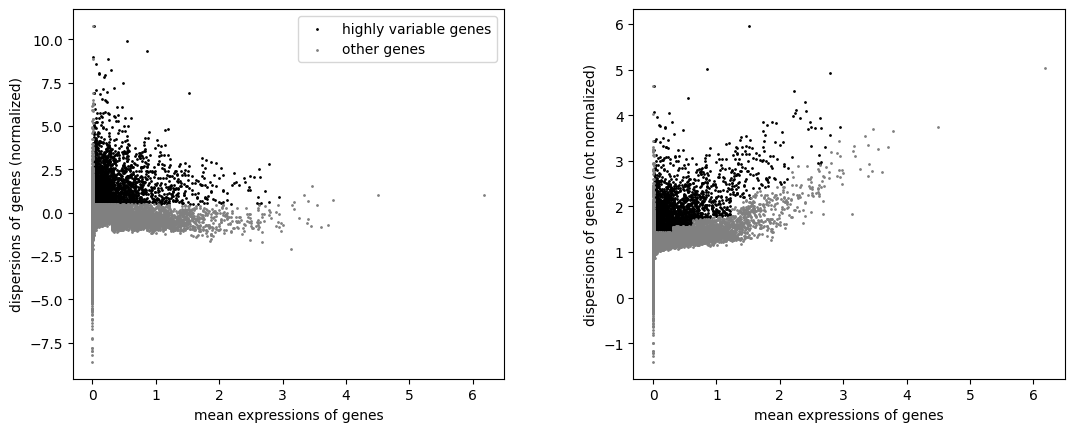

In [15]:
# identify highly variable genes
sc.pp.highly_variable_genes(non_neurons, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

# plot highly variable genes
sc.pl.highly_variable_genes(non_neurons)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. Next, filter for highly variable genes.

See [this issue](https://github.com/scverse/scanpy/issues/967) for a discussion on what should be stored in the `.raw` attribute.

In [16]:
# freeze state
non_neurons.raw = non_neurons

# filter for highly variable genes
# non_neurons = non_neurons[:, non_neurons.var.highly_variable]

# print object
non_neurons

AnnData object with n_obs × n_vars = 885298 × 24501
    obs: 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'dissection', 'cell_cycle_score', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_type', 'gene_description', 'gene_start', 'gene_end', 'ncbi_gene_description', 'ncbi_gene_id', 'gene_stable_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_con

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.

In [17]:
# regress out total counts per cell and the percentage of mitochondrial genes expressed
# sc.pp.regress_out(non_neurons, ['total_counts', 'pct_counts_mt'])

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [18]:
# scale to unit variance
sc.pp.scale(non_neurons, max_value = 10)

# print object
non_neurons

AnnData object with n_obs × n_vars = 885298 × 24501
    obs: 'ROIGroup', 'ROIGroupCoarse', 'ROIGroupFine', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'dissection', 'cell_cycle_score', 'sample_id', 'cluster_id', 'subcluster_id', 'supercluster_term', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_type', 'gene_description', 'gene_start', 'gene_end', 'ncbi_gene_description', 'ncbi_gene_id', 'gene_stable_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    

# Clusters and Subclusters

In [19]:
# select columns from non_neurons.obs
# with cluster_id and subcluster_id only, 297 rows
# with supercluster_term, still 297 rows
# with ROIGroupCoarse, 2185 rows
# with ROIGroupFine, 2827 rows
cluster_list = non_neurons.obs[['supercluster_term', 'cluster_id', 'subcluster_id']]

# node_columns = ['ROIGroupCoarse', 'ROIGroupFine', 'supercluster_term', 'cluster_id', 'subcluster_id', 'CELLxGENE_ontology_term_id', 'tissue_ontology_term_id']
# cluster_data = non_neurons.obs[node_columns]

# drop duplicates and order by cluster_id, subcluster_id
cluster_list = cluster_list.drop_duplicates()
cluster_list = cluster_list.sort_values(by = ['cluster_id', 'subcluster_id'], ascending = True).reset_index(drop = True)
cluster_list

,supercluster_term,cluster_id,subcluster_id
0,Microglia,4,3267
1,Microglia,4,3268
2,Microglia,4,3269
3,Microglia,5,3291
4,Microglia,5,3292
...,...,...,...
292,Choroid plexus,81,3177
293,Choroid plexus,81,3181
294,Choroid plexus,82,3173
295,Choroid plexus,82,3175


Next, get lists of cluster IDs and subcluster IDs. Find markers for all clusters and subclusters.

In [20]:
# get supercluster terms
supercluster_terms = cluster_list['supercluster_term'].unique()

# get cluster IDs
cluster_ids = cluster_list['cluster_id'].unique()

# get subcluster IDs
subcluster_ids = cluster_list['subcluster_id'].unique()

# print number of clusters, subclusters, and superclusters
print('Number of superclusters:', len(supercluster_terms))
print('Number of clusters:', len(cluster_ids))
print('Number of subclusters:', len(subcluster_ids))

Number of superclusters: 10
Number of clusters: 79
Number of subclusters: 297


# Dimensionality Reduction Visualization

Rename the UMAP and t-SNE names in the [`.obsm` property](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.obsm.html).

In [21]:
print("Previous names: ", non_neurons.obsm_keys())

# rename 'X_UMAP' to 'x_umap'
non_neurons.obsm['umap'] = non_neurons.obsm['X_UMAP']
del non_neurons.obsm['X_UMAP']

# rename 'X_UMAP' to 'x_umap'
non_neurons.obsm['tsne'] = non_neurons.obsm['X_tSNE']
del non_neurons.obsm['X_tSNE']

print("Updated names: ", non_neurons.obsm_keys())

Previous names:  ['X_UMAP', 'X_tSNE']
Updated names:  ['umap', 'tsne']


Plot cell type markers from Figure 1.

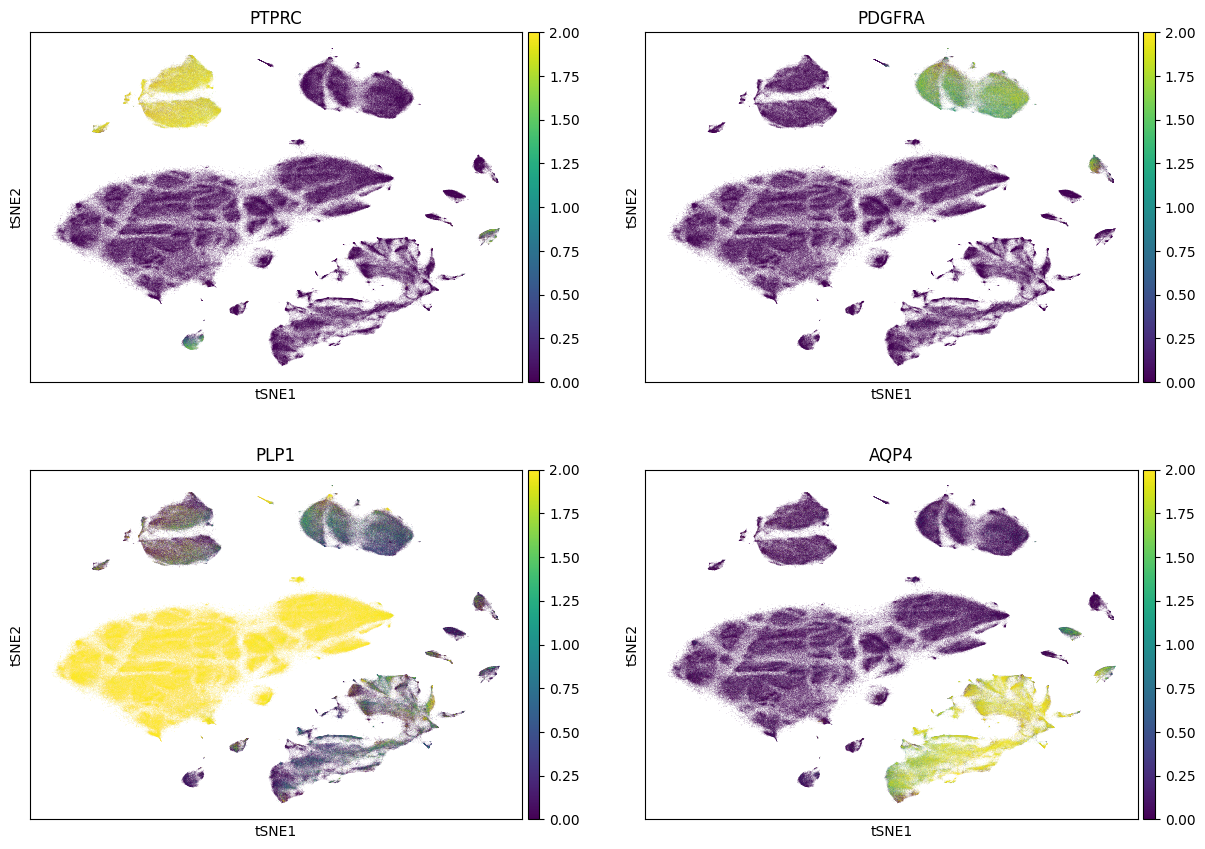

In [22]:
# get index values for gene symbols
# neuron_markers = ['INA', 'SLC17A6', 'SLC17A7', 'SLC32A1']
# non_neuron_markers = ['PTPRC', 'CLDN5', 'ACTA2', 'LUM', 'PDGFRA', 'SOX10', 'PLP1', 'AQP4', 'FOXJ1', 'TTR']
non_neuron_markers = ['PTPRC', 'PDGFRA', 'PLP1', 'AQP4']
genes_to_plot = non_neuron_markers # non_neurons.var[non_neurons.var['gene_symbols'].isin(non_neuron_markers)].index.values

# create t-SNE plot
fig = sc.pl.tsne(non_neurons, color = genes_to_plot, #.index.values, title = genes_to_plot.gene_symbols, 
                 vmax = 2, ncols = 2, use_raw = True, return_fig = True)

# save figure
fig.savefig(project_config.PROJECT_DIR / 'Results' / 'CELLxGENE' / 'non_neuron_markers.png', dpi = 300, bbox_inches = 'tight')

Check other relevant or interesting markers, for example, from [Muñoz-Castro and Noori et al., 2022](https://doi.org/10.1186/s12974-022-02383-4).

In [23]:
# check for name inclusion
# non_neurons.var[non_neurons.var.index.str.contains('SLC1A2')]
# astrocyte_microglia_markers = ['ALDH1L1', 'GFAP', 'GLUL', 'SLC1A2', 'SLC1A3', 'VIM', 'AIF1', 'TMEM119', 'CD68', 'HLA-DRA']

# # create t-SNE plot
# fig = sc.pl.tsne(non_neurons, color = ['AQP4', 'ALDH1L1', 'GFAP', 'GLUL'], #.index.values, title = genes_to_plot.gene_symbols, 
#                  vmax = 2, ncols = 2, use_raw = True, return_fig = True)

# Marker Gene Identification

We use [`scanpy.tl.rank_genes_groups`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html) to identify marker genes for each supercluster, cluster, and subcluster. We use the `t-test` method to compute the ranking. See [this discussion](https://github.com/scverse/scanpy/issues/2029) for information about using raw vs. scaled data.

In [24]:
# compute total number of cells in each supercluster
non_neurons.obs.supercluster_term.value_counts()

Oligodendrocyte                        489306
Astrocyte                              154679
Oligodendrocyte precursor              105640
Microglia                               91432
Vascular                                 9792
Fibroblast                               9036
Bergmann glia                            8039
Choroid plexus                           7404
Ependymal                                5432
Committed oligodendrocyte precursor      4538
Name: supercluster_term, dtype: int64

Find supercluster marker genes.

In [25]:
# check for NA values in data matrix
# np.any(np.isnan(non_neurons.X))

# find supercluster marker genes
sc.tl.rank_genes_groups(non_neurons, 'supercluster_term', method = 't-test', key_added = 'supercluster_markers', use_raw = True)

Visualize supercluster marker genes.

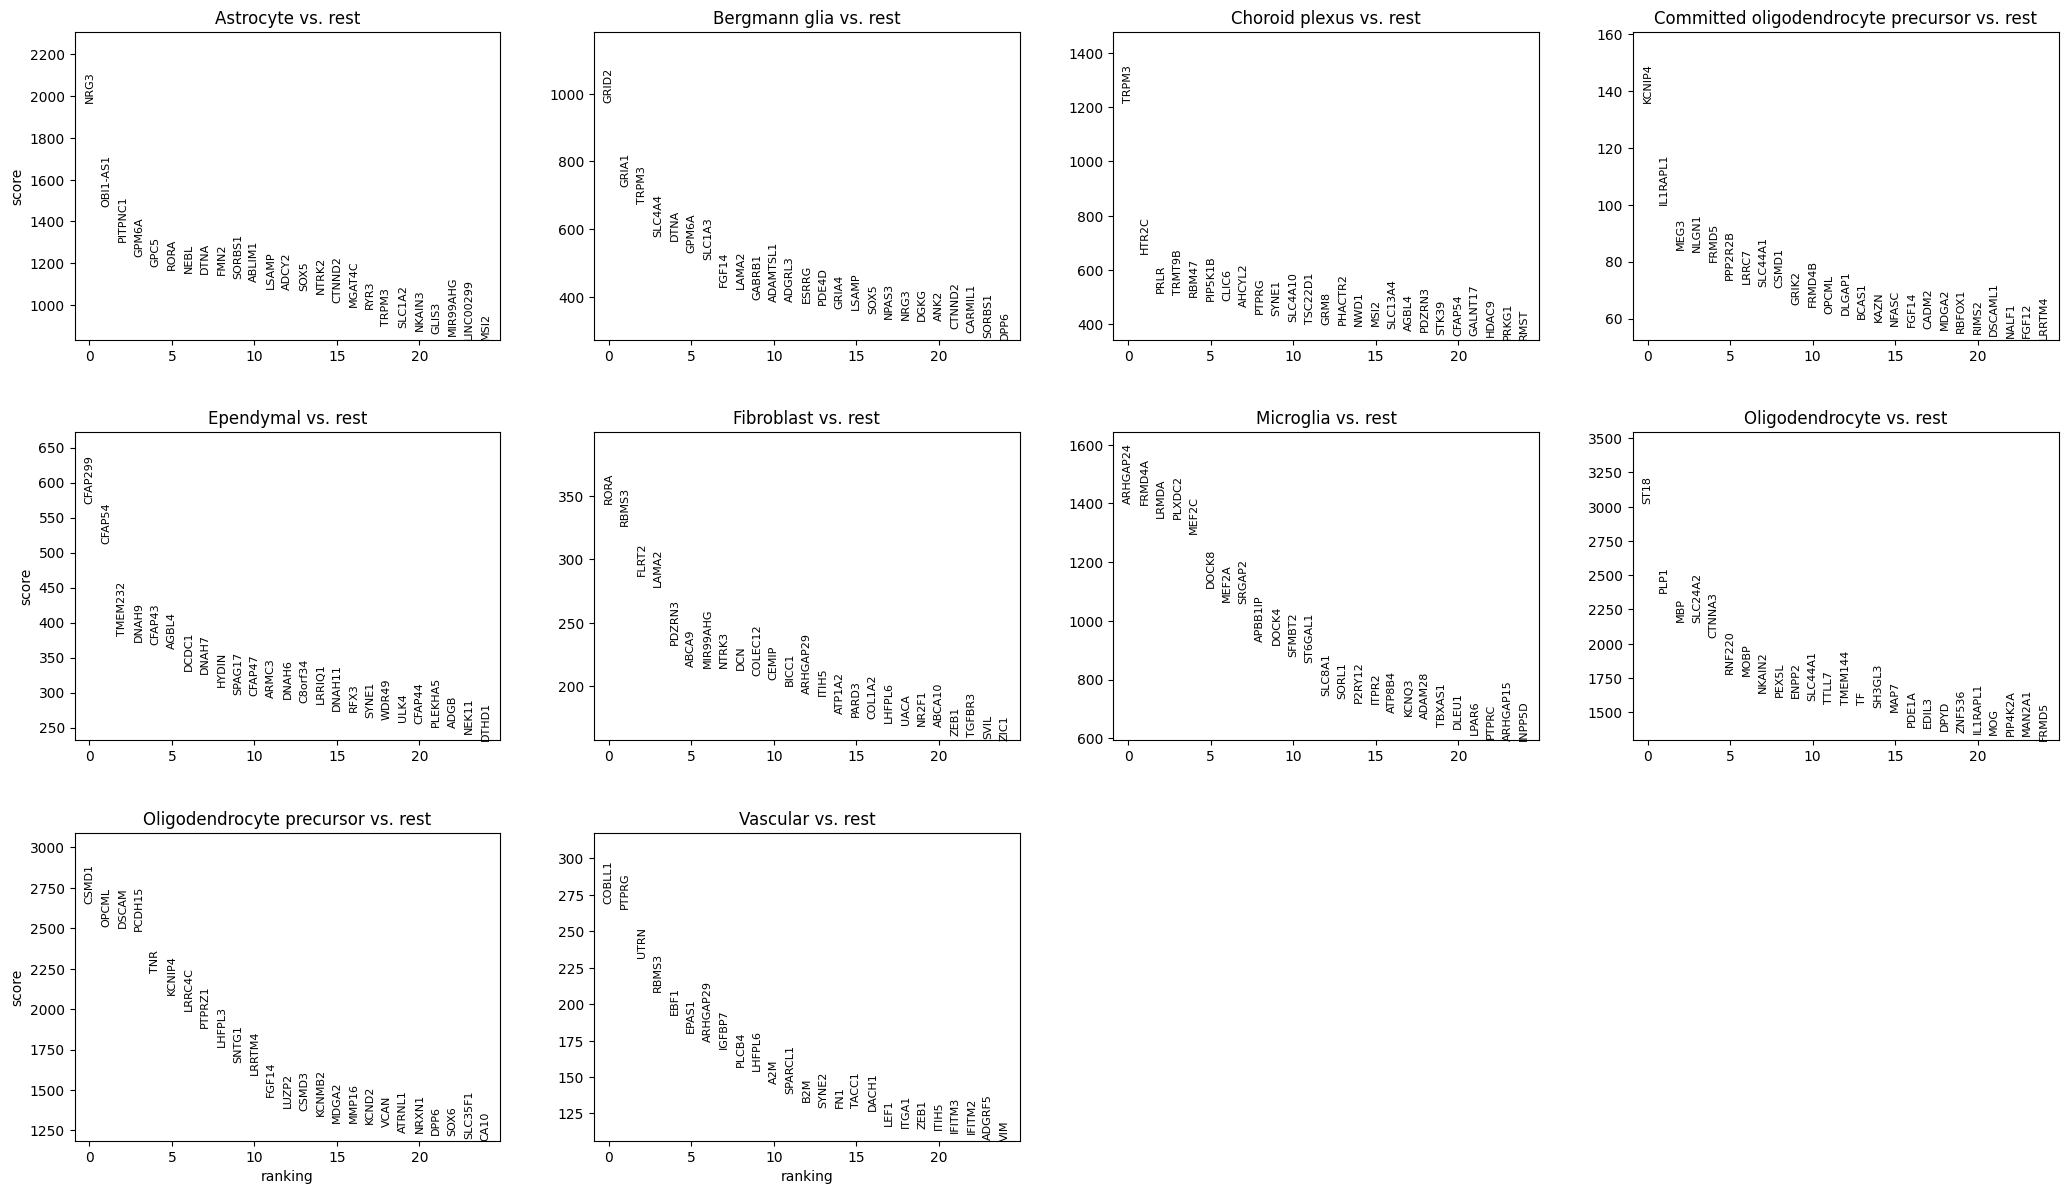

In [26]:
# visualize supercluster marker genes
# sc.pl.rank_genes_groups_dotplot(non_neurons, n_genes = 5, key = 'supercluster_markers', key = 'supercluster_markers', standard_scale = 'var', use_raw = True)
sc.pl.rank_genes_groups(non_neurons, n_genes = 25, key = 'supercluster_markers', sharey = False)

Print top 20 supercluster marker genes.

In [27]:
pd.DataFrame(non_neurons.uns['supercluster_markers']['names']).head(20)

,Astrocyte,Bergmann glia,Choroid plexus,Committed oligodendrocyte precursor,Ependymal,Fibroblast,Microglia,Oligodendrocyte,Oligodendrocyte precursor,Vascular
0,NRG3,GRID2,TRPM3,KCNIP4,CFAP299,RORA,ARHGAP24,ST18,CSMD1,COBLL1
1,OBI1-AS1,GRIA1,HTR2C,IL1RAPL1,CFAP54,RBMS3,FRMD4A,PLP1,OPCML,PTPRG
2,PITPNC1,TRPM3,PRLR,MEG3,TMEM232,FLRT2,LRMDA,MBP,DSCAM,UTRN
3,GPM6A,SLC4A4,TRMT9B,NLGN1,DNAH9,LAMA2,PLXDC2,SLC24A2,PCDH15,RBMS3
4,GPC5,DTNA,RBM47,FRMD5,CFAP43,PDZRN3,MEF2C,CTNNA3,TNR,EBF1
5,RORA,GPM6A,PIP5K1B,PPP2R2B,AGBL4,ABCA9,DOCK8,RNF220,KCNIP4,EPAS1
6,NEBL,SLC1A3,CLIC6,LRRC7,DCDC1,MIR99AHG,MEF2A,MOBP,LRRC4C,ARHGAP29
7,DTNA,FGF14,AHCYL2,SLC44A1,DNAH7,NTRK3,SRGAP2,NKAIN2,PTPRZ1,IGFBP7
8,FMN2,LAMA2,PTPRG,CSMD1,HYDIN,DCN,APBB1IP,PEX5L,LHFPL3,PLCB4
9,SORBS1,GABRB1,SYNE1,GRIK2,SPAG17,COLEC12,DOCK4,ENPP2,SNTG1,LHFPL6


Create a DataFrame with the marker genes for each supercluster; then, save to file.

In [28]:
# create table
supercluster_result = non_neurons.uns['supercluster_markers']
groups = supercluster_result['names'].dtype.names
supercluster_markers = pd.DataFrame(
    {group + '_' + key: supercluster_result[key][group]
     for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

# save supercluster markers
supercluster_markers.to_csv(output_dir / 'non_neuron_markers' / 'supercluster_markers.csv', index = False)

# show head
supercluster_markers.head()

,Astrocyte_names,Astrocyte_scores,Astrocyte_pvals,Astrocyte_pvals_adj,Astrocyte_logfoldchanges,Bergmann glia_names,Bergmann glia_scores,Bergmann glia_pvals,Bergmann glia_pvals_adj,Bergmann glia_logfoldchanges,...,Oligodendrocyte precursor_names,Oligodendrocyte precursor_scores,Oligodendrocyte precursor_pvals,Oligodendrocyte precursor_pvals_adj,Oligodendrocyte precursor_logfoldchanges,Vascular_names,Vascular_scores,Vascular_pvals,Vascular_pvals_adj,Vascular_logfoldchanges
0,NRG3,1965.843384,0.0,0.0,5.889554,GRID2,972.302002,0.0,0.0,5.709754,...,CSMD1,2650.773438,0.0,0.0,7.056290,COBLL1,268.889343,0.0,0.0,7.947971
1,OBI1-AS1,1472.643555,0.0,0.0,9.172023,GRIA1,725.460266,0.0,0.0,7.716415,...,OPCML,2512.109863,0.0,0.0,8.155631,PTPRG,265.852692,0.0,0.0,4.906771
2,PITPNC1,1304.524170,0.0,0.0,5.457650,TRPM3,674.339417,0.0,0.0,5.446500,...,DSCAM,2503.815186,0.0,0.0,7.218746,UTRN,232.285263,0.0,0.0,4.706234
3,GPM6A,1234.457886,0.0,0.0,5.401637,SLC4A4,578.952209,0.0,0.0,5.916433,...,PCDH15,2484.352295,0.0,0.0,9.326707,RBMS3,208.955215,0.0,0.0,3.799976
4,GPC5,1182.879517,0.0,0.0,6.900638,DTNA,565.447449,0.0,0.0,3.627694,...,TNR,2225.440918,0.0,0.0,7.595222,EBF1,193.075455,0.0,0.0,7.281542


Iterate over superclusters to get cluster marker genes within each supercluster.

In [29]:
# iterate over superclusters
for supercluster in supercluster_terms:

    # set key name
    key_name = supercluster + '_markers'

    # get cluster IDs
    supercluster_members = cluster_list[cluster_list['supercluster_term'] == supercluster]['cluster_id'].unique().tolist()

    # print number of clusters
    print('Clusters in {}: {}'.format(supercluster, len(supercluster_members)))

    if(len(supercluster_members) > 1):

        # filter for supercluster members
        # instead of using groups = supercluster_members (which would look for markers across all supercluster members)
        supercluster_data = non_neurons[non_neurons.obs['cluster_id'].isin(supercluster_members), :].copy()

        # print number of cells
        print('Cells in {}: {}'.format(supercluster, supercluster_data.n_obs))

        # assign number of cells to cluster_list
        cluster_list.loc[cluster_list['supercluster_term'] == supercluster, 'supercluster_n_cells'] = supercluster_data.n_obs

        # find cluster marker genes
        sc.tl.rank_genes_groups(supercluster_data, 'cluster_id', method = 't-test', key_added = key_name, use_raw = True)

        # get cluster marker results
        cluster_result = supercluster_data.uns[key_name] # instead of non_neurons.uns['cluster_markers']
        groups = cluster_result['names'].dtype.names
        cluster_markers = pd.DataFrame(
        {group + '_' + key: cluster_result[key][group]
        for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

        # save cluster markers
        cluster_markers.to_csv(output_dir / 'non_neuron_markers' / (supercluster + '_markers.csv'), index = False)

    else:

        # print error message
        print('Skipping {} because it has only one cluster.'.format(supercluster))

Clusters in Microglia: 9
Cells in Microglia: 91432
Clusters in Vascular: 11
Cells in Vascular: 9792
Clusters in Fibroblast: 8
Cells in Fibroblast: 9036
Clusters in Oligodendrocyte precursor: 5
Cells in Oligodendrocyte precursor: 105640
Clusters in Committed oligodendrocyte precursor: 7
Cells in Committed oligodendrocyte precursor: 4538
Clusters in Oligodendrocyte: 8
Cells in Oligodendrocyte: 489306
Clusters in Bergmann glia: 1
Skipping Bergmann glia because it has only one cluster.
Clusters in Astrocyte: 13
Cells in Astrocyte: 154679
Clusters in Ependymal: 10
Cells in Ependymal: 5432
Clusters in Choroid plexus: 7
Cells in Choroid plexus: 7404


Identify marker genes for the subclusters and save to file. Print log messages every 10 clusters.

In [30]:
# iterate over superclusters
for cluster_index, cluster in enumerate(cluster_ids):

    # set key name
    key_name = 'cluster_' + str(cluster) + '_markers'

    # get cluster IDs
    cluster_members = cluster_list[cluster_list['cluster_id'] == cluster]['subcluster_id'].unique().tolist()

    # print number of clusters
    # print('Subclusters in cluster {}: {}'.format(cluster, len(cluster_members)))

    if(len(cluster_members) > 1):

        # filter for cluster members
        cluster_data = non_neurons[non_neurons.obs['subcluster_id'].isin(cluster_members), :].copy()

        # print number of cells
        # print('Cells in cluster {}: {}'.format(cluster, cluster_data.n_obs))

        # assign number of cells to cluster_list
        cluster_list.loc[cluster_list['cluster_id'] == cluster, 'cluster_n_cells'] = cluster_data.n_obs

        # iterate over subclusters
        for subcluster in cluster_members:

            # assign number of cells to cluster_list
            cluster_list.loc[cluster_list['subcluster_id'] == subcluster, 'subcluster_n_cells'] = cluster_data[cluster_data.obs['subcluster_id'] == subcluster, :].n_obs

        # print cluster index to file in same line
        print('Cluster {} of {}: {} cells'.format(cluster_index + 1, len(cluster_ids), cluster_data.n_obs), end = '\r')

        # find cluster marker genes
        sc.tl.rank_genes_groups(cluster_data, 'subcluster_id', method = 't-test', key_added = key_name, use_raw = True)

        # get cluster marker results
        subcluster_result = cluster_data.uns[key_name] # instead of non_neurons.uns['cluster_markers']
        groups = subcluster_result['names'].dtype.names
        subcluster_markers = pd.DataFrame(
        {group + '_' + key: subcluster_result[key][group]
        for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

        # save cluster markers
        subcluster_markers.to_csv(output_dir / 'non_neuron_markers' / ('cluster_' + str(cluster) + '_markers.csv'), index = False)

    else:

        # print error message
        # print('Skipping {} because it has only one subcluster.'.format(supercluster))
        pass

# Save Data

Save the AnnData object to an `.h5ad` file.

In [31]:
# save cluster list
cluster_list.to_csv(output_dir / 'non_neuron_markers' / 'cluster_list.csv', index = False)

# save AnnData object
non_neurons.write_h5ad(output_dir /  'non_neurons_processed.h5ad')

If needed, read back the object. Remember to run the first two cells to load libraries and set paths.

In [3]:
# read back AnnData object
non_neurons = sc.read_h5ad(output_dir / 'non_neurons_processed.h5ad')

Write gene-level (*i.e.*, `var`) and cell-level (*i.e.*, `obs`) metadata to file for downstream analysis during cell type construction.

In [6]:
# write gene metadata to file
non_neurons.var.to_csv(output_dir / 'non_neurons_var_gene_metadata.csv', index = True)

# write cell metadata to file
non_neurons.obs.to_csv(output_dir / 'non_neurons_obs_cell_metadata.csv', index = True)